In [1]:
import os
import sys
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

sys.path.append("../")

import torch
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import numpy as np
import cv2
import json
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from model import build_model
from clip_ import load, tokenize, similarity_score
from vit_cam import interpret_vit, interpret_vit_overlapped, vit_relevance
from rn_cam import interpret_rn, interpret_rn_overlapped, rn_relevance
sys.path.append("../pytorch-grad-cam")
from pytorch_grad_cam import GradCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad
from pickle_loader import Pickle_data_loader

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
model_rn, preprocess = load("RN101", device=device, jit=False)
model_vit, preprocess = load("ViT-B/32", device=device, jit=False)

100%|███████████████████████████████████████| 292M/292M [00:12<00:00, 24.3MiB/s]


In [5]:
model_types = ["ViT", "ResNet"]

font = {
    'size': 40,
}

ori_preprocess = Compose([
        Resize((224), interpolation=Image.BICUBIC),
        CenterCrop(size=(224, 224)),
        ToTensor()])

res_dir = "../../results/affectnet/"
if not os.path.exists(res_dir):
    os.mkdir(res_dir)

# Attention Bias

In [6]:
image_ids = []
root = "../../Images/affectnet_samples/"
texts  = ["this person is sad", "this person is happy"]
for directory in os.listdir(root):
    for file in os.listdir(root+directory):
        if file.endswith(".jpg"):
            image_ids.append(f"{directory}/{file}")

## AffectNet

/home/mamooler/miniconda/envs/habitat/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


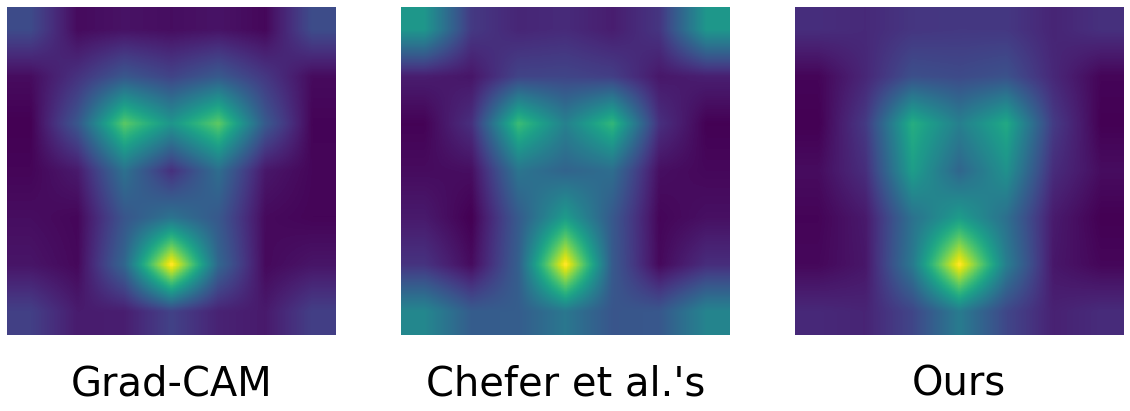

In [7]:
plt.figure(figsize=(20, 20))

for method_id, method in enumerate(["gradcam", "all grads", "last grad"]):  
    
    if method=="gradcam":
        title = "Grad-CAM"
    elif method=="all grads":
        title = "Chefer et al.'s"
    else:
        title = "Ours"
    
    for id_, img_id in enumerate(image_ids):

        img_path =  os.path.join(root, img_id)
        image = ori_preprocess(Image.open(img_path))
        p_image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

        for i,text in enumerate(texts):
            t_text = tokenize(text).to(device)
            text_features = model_vit.encode_text(t_text)
          
            relevance, _ = vit_relevance(p_image.type(model_vit.dtype), text_features, model_vit.visual, device, method=method)
              
            relevance = np.expand_dims(relevance, axis=0)
            if id_ == 0:
                attentions = relevance
            else:
                attentions = np.concatenate((attentions, relevance), axis=0)
            
                
    mean = np.mean(attentions, axis=0)
    mean = np.float32(mean/np.max(mean))
    
    plt.subplot(1,3,1+method_id)
    plt.imshow(mean)
    plt.axis('off')
    plt.title(title, **font, y=-0.20)
    
plt.savefig(res_dir + f'attention_bias_ViT_comparison.png', bbox_inches='tight')

## ViT vs ResNet

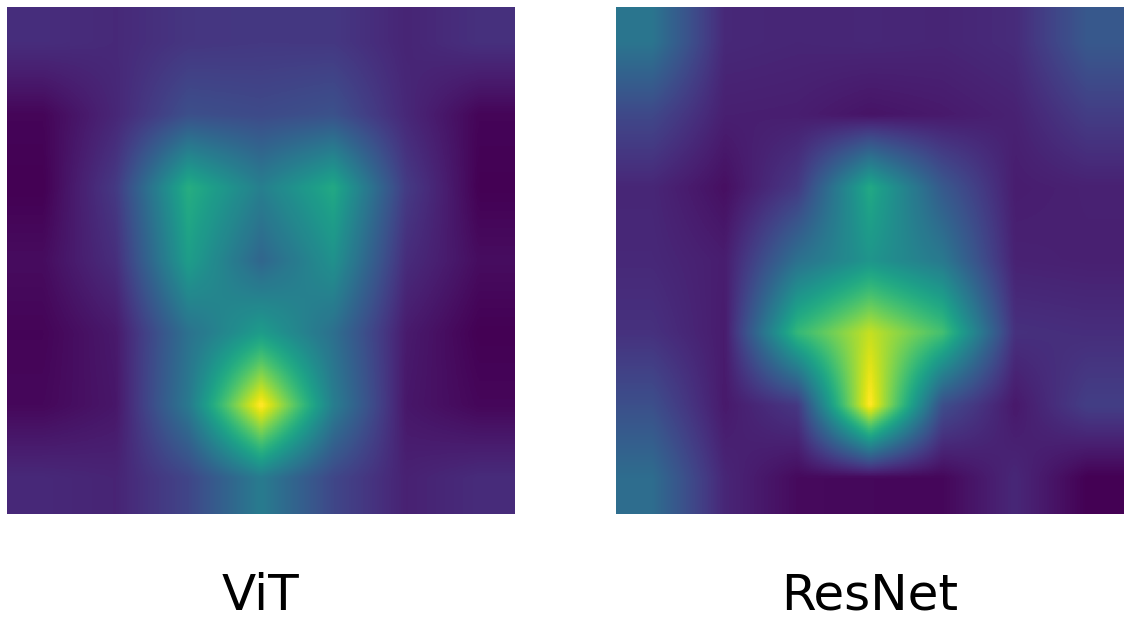

In [10]:
plt.figure(figsize=(20, 20))

for model_id, model_type in enumerate(model_types):  
    
    for id_, img_id in enumerate(image_ids):

        img_path =  os.path.join(root, img_id)
        image = ori_preprocess(Image.open(img_path))
        p_image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

        for i,text in enumerate(texts):
            t_text = tokenize(text).to(device)
            
            if model_type=="ViT":
                text_features = model_vit.encode_text(t_text)
                relevance, _ = vit_relevance(p_image.type(model_vit.dtype), text_features, model_vit.visual, device)
                
            else:
                text_features = model_rn.encode_text(t_text)
                relevance, _ = rn_relevance(p_image.type(model_rn.dtype), text_features, model_rn.visual, GradCAM, device)
                
            relevance = np.expand_dims(relevance, axis=0)
            if id_ == 0:
                attentions = relevance
            else:
                attentions = np.concatenate((attentions, relevance), axis=0)
            
                
    mean = np.mean(attentions, axis=0)
    mean = np.float32(mean/np.max(mean))
    
    plt.subplot(1,2,1+model_id)
    plt.imshow(mean)
    plt.axis('off')
    plt.title(f"{model_type}", **font, y=-0.20)
    
plt.savefig(res_dir + f'attention_bias_ViT_vs_ResNet.png', bbox_inches='tight')